# 相关性&线性回归

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as si

In [2]:
apple = yf.download('AAPL', start='2022-11-01', end='2023-11-01')
tesla = yf.download('TSLA', start='2022-11-01', end='2023-11-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


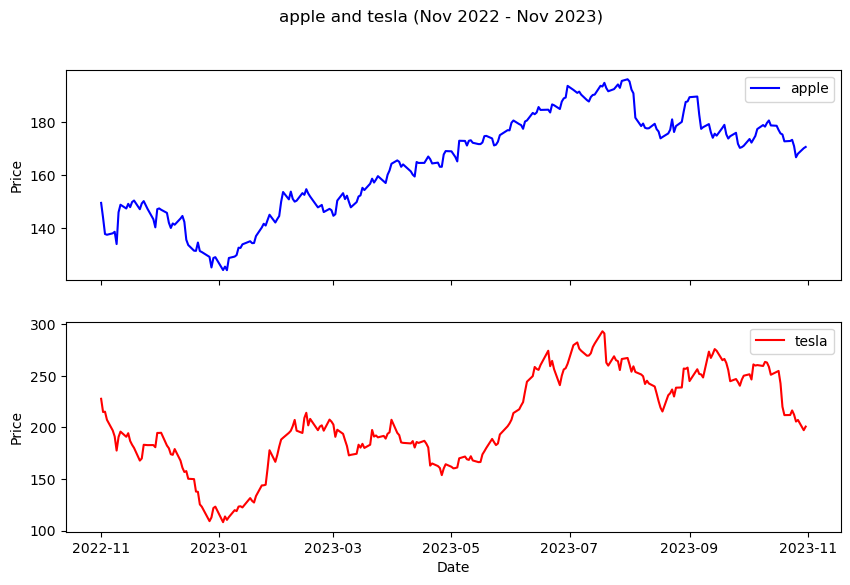

In [4]:
# Subplots
fig, axs = plt.subplots(2, sharex=True, figsize=(10, 6))
fig.suptitle('apple and tesla (Nov 2022 - Nov 2023)')

# Plotting apple
axs[0].plot(apple['Adj Close'], label='apple', color='blue')
axs[0].set_ylabel('Price')
axs[0].legend()

# Plotting tesla
axs[1].plot(tesla['Adj Close'], label='tesla', color='red')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].legend()

plt.show()

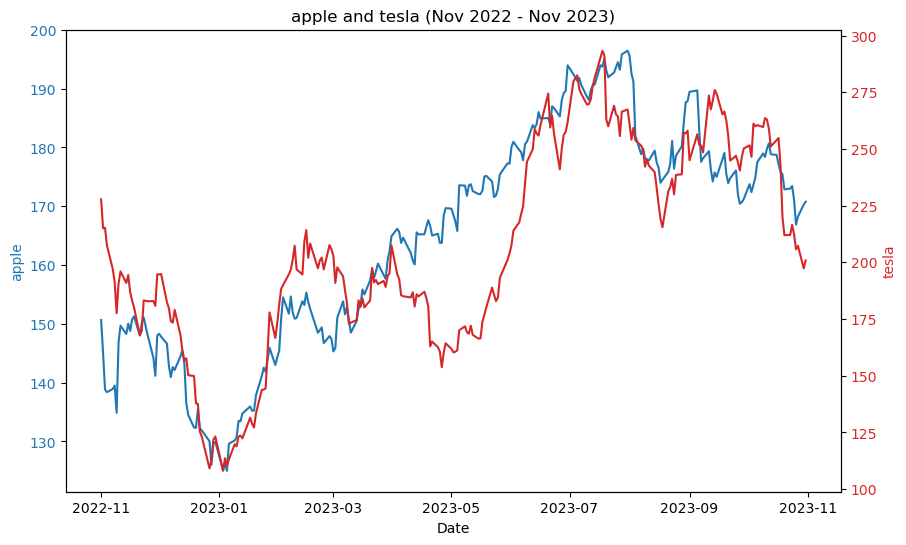

In [5]:
# Create figure and subplot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting apple Index
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('apple', color=color)  # Y label for S&P 500
ax1.plot(apple['Close'], color=color)  # S&P 500 plot
ax1.tick_params(axis='y', labelcolor=color)  # Color for S&P 500 Y-axis labels

# Create a second Y-axis for plotting tesla
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('tesla', color=color)  # Y label for VIX
ax2.plot(tesla['Close'], color=color)  # VIX plot
ax2.tick_params(axis='y', labelcolor=color)  # Color for VIX Y-axis labels

# Adding title and displaying the plot
plt.title('apple and tesla (Nov 2022 - Nov 2023)')
plt.show()

In [6]:
# Calculate log returns
apple['LogRet'] = np.log(apple['Close'] / apple['Close'].shift(1))
tesla['LogRet'] = np.log(tesla['Close'] / tesla['Close'].shift(1))

# Calculate correlation
correlation = apple['LogRet'].corr(tesla['LogRet'])

# Print the correlation
print(f"The correlation between the log returns of apple and tesla from Nov 2022 to Nov 2023 is {correlation:.4f}")

The correlation between the log returns of apple and tesla from Nov 2022 to Nov 2023 is 0.4821


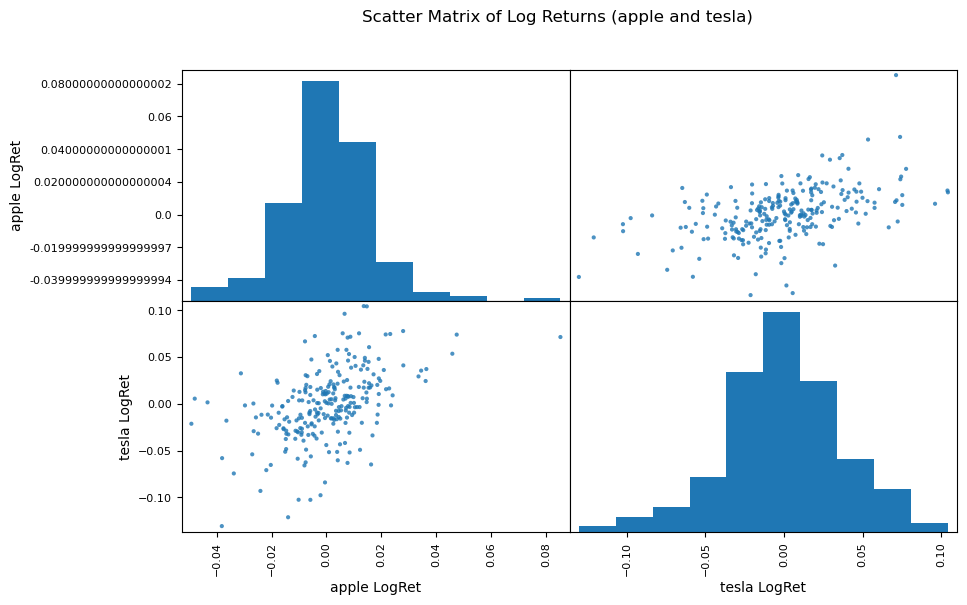

In [8]:
# Creating a DataFrame with log returns
data = pd.DataFrame({'apple LogRet': apple['LogRet'], 'tesla LogRet': tesla['LogRet']}).dropna()

# Scatter matrix
pd.plotting.scatter_matrix(data, alpha=0.8, figsize=(10, 6), diagonal='hist')
plt.suptitle('Scatter Matrix of Log Returns (apple and tesla)')
plt.show()

In [9]:
# Linear fitting
fit = np.polyfit(data['apple LogRet'], data['tesla LogRet'], 1)

# Extracting and printing the slope and intercept
slope, intercept = fit
print(f"The linear regression model is: Y = {slope:.4f}X + {intercept:.4f}")

The linear regression model is: Y = 1.1539X + -0.0011


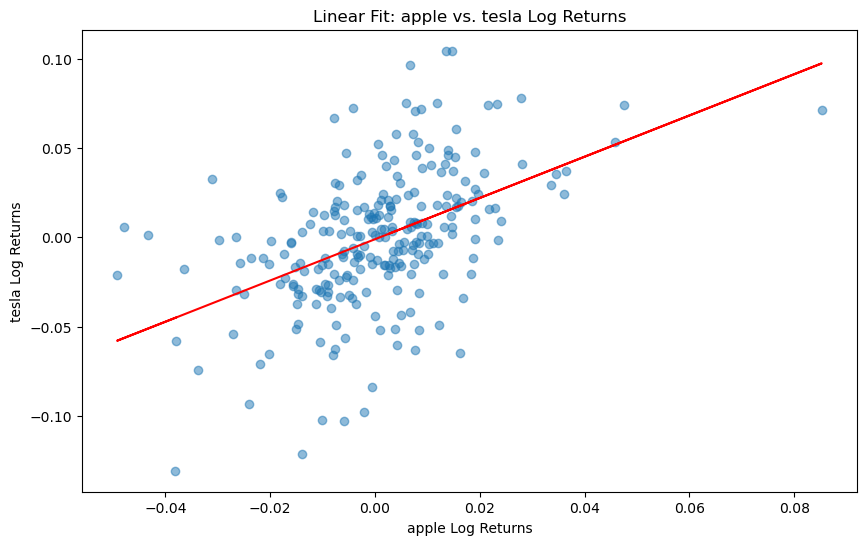

In [14]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(data['apple LogRet'], data['tesla LogRet'], alpha=0.5)
plt.plot(data['apple LogRet'], np.polyval(fit, data['apple LogRet']), color='red')
plt.title('Linear Fit: apple vs. tesla Log Returns')
plt.xlabel('apple Log Returns')
plt.ylabel('tesla Log Returns')
plt.show()

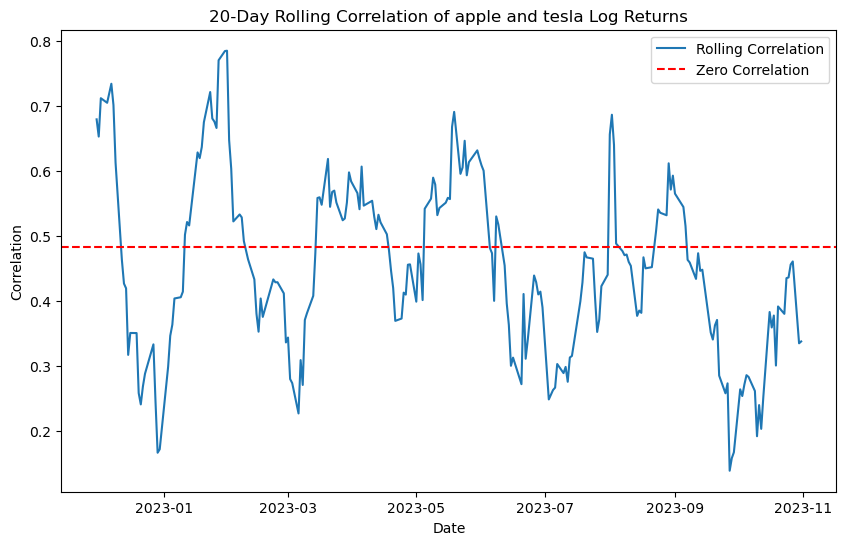

In [15]:
# Calculating rolling correlation with a window of 20 trading days
rolling_corr = data['apple LogRet'].rolling(window=20).corr(data['tesla LogRet'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(rolling_corr, label='Rolling Correlation')
plt.axhline(correlation, color='red', linestyle='--', label='Zero Correlation')
plt.title('20-Day Rolling Correlation of apple and tesla Log Returns')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()


# option price&对比

In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as si

In [18]:
def black_scholes_call(S, K, T, r, sigma):
    """
    S: Current price of the underlying asset
    K: Option strike price
    T: Time to expiration
    r: Risk-free rate
    sigma: Volatility
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call_price

In [22]:
# Sample input values
S = yf.download('AAPL', start='2023-10-13', end='2023-10-14')['Adj Close'].item()   # Using the last available closing price as current price
K = 185
T = 1/12  # One month to expiration
r = 0.045  # Risk-free rate 4.5%
sigma = apple['LogRet'].std() * np.sqrt(252)  # Annualized volatility

[*********************100%%**********************]  1 of 1 completed


In [23]:
# Calculate and print the theoretical price
bs_price = black_scholes_call(S, K, T, r, sigma)
print(f"Theoretical Black-Scholes Price of the Call Option: ${bs_price:.2f}")

Theoretical Black-Scholes Price of the Call Option: $2.87


In [25]:
# Define the ticker and retrieve data
ticker = "AAPL"
stock = yf.Ticker(ticker)

# Get option chain for a specific expiration date
opt = stock.option_chain('2023-11-17')

# Retrieve the call option with a strike price of $4300
call_185 = opt.calls.loc[opt.calls['strike'] == 185]

# Extract and print the last traded price
market_price = call_185['lastPrice'].values[0]
print(f"Market Price of the Call Option: ${market_price:.2f}")

Market Price of the Call Option: $3.00


In [26]:
print(f"Difference between Market and Black-Scholes Price: ${market_price - bs_price:.2f}")

Difference between Market and Black-Scholes Price: $0.13


# 分别用BS Model和BSM Model计算option price

In [28]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as si

In [29]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [37]:
data = yf.download('AAPL', start='2022-11-14', end='2023-11-14')

[*********************100%%**********************]  1 of 1 completed


In [38]:
data['log_return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

In [39]:
vol=np.sqrt(252)*data['log_return'].std()
vol

0.22817316230767098

In [40]:
# Calculate the option price
option_price = euro_option_bs(186.91, 185, 1/52, 0.045, vol, 'call')

# Print the result
print(f"The European call option price is: ${option_price:.2f}")


The European call option price is: $3.53


In [41]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [42]:
data = yf.download('AAPL', start='2022-11-14', end='2023-11-14')

[*********************100%%**********************]  1 of 1 completed


In [43]:
data['log_return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

In [44]:
vol=np.sqrt(252)*data['log_return'].std()
vol

0.22817316730309

In [45]:
# Calculate the option price using the BSM model
option_price_bsm = euro_option_bsm(186.91, 185, 1/52, 0.045, 0.0052, vol, 'call')

# Print the result
print(f"The European call option price (with dividends) is: ${option_price_bsm:.2f}")

The European call option price (with dividends) is: $3.51


# 年化收益率和风险

In [46]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [47]:
data = yf.download('AAPL', start='2022-11-14', end='2023-11-14')

[*********************100%%**********************]  1 of 1 completed


In [48]:
data['Daily_Return'] = data['Adj Close'].pct_change()

In [49]:
annualized_return = data['Daily_Return'].mean() * 252

In [50]:
annualized_volatility = data['Daily_Return'].std() * np.sqrt(252)

In [51]:
print(f'Annualized Return: {annualized_return * 100:.2f}%')
print(f'Annualized Volatility: {annualized_volatility * 100:.2f}%')

Annualized Return: 25.36%
Annualized Volatility: 22.82%


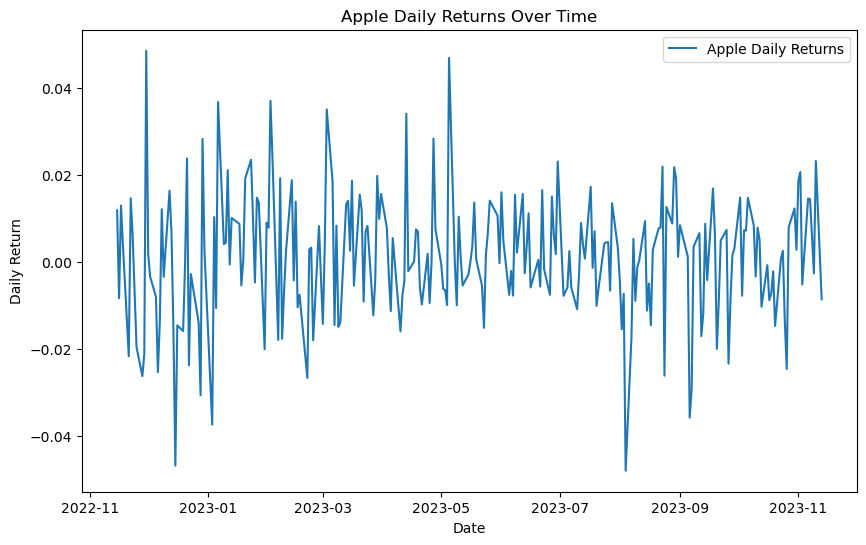

In [52]:
plt.figure(figsize=(10,6))
plt.plot(data['Daily_Return'], label='Apple Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Apple Daily Returns Over Time')
plt.legend()
plt.show()

# CDD

In [53]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

In [54]:
start = datetime(2023, 7, 1)
end = datetime(2023, 8, 31)

In [55]:
location = Point(48.8566, 2.3522, 35)# (latitude, longitude, and altitude) 

In [56]:
data = Daily(location, start, end)
data = data.fetch()

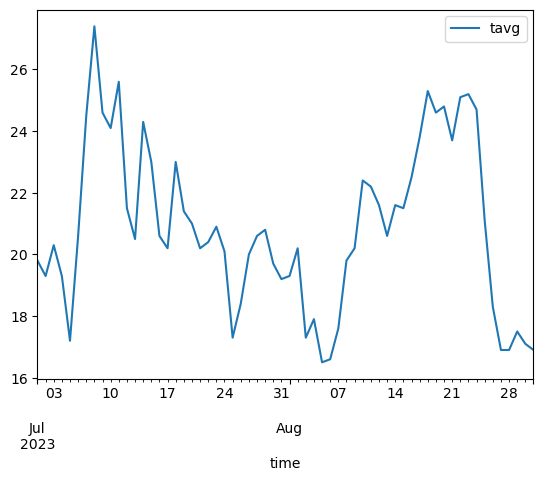

In [57]:
data.plot(y=['tavg'])
plt.show()

In [58]:
T_base = 18
cdds = [max(temp - T_base, 0) for temp in data.tavg]

In [59]:
strike = 100
total_cdd = sum(cdds)
payoff = max(total_cdd - strike, 0)

In [60]:
print("Total CDD:", total_cdd)
print("Option Payoff:", payoff)

Total CDD: 189.79999999999998
Option Payoff: 89.79999999999998


# HDD

In [61]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

In [85]:
start = datetime(2023, 8, 1)
end = datetime(2023, 9, 30)

In [86]:
location = Point(39.916668, 116.383331, 43)# (latitude, longitude, and altitude) 

In [87]:
data = Daily(location, start, end)
data = data.fetch()

In [88]:
T_base = 18
hdds = [max(T_base - temp, 0) for temp in data.tavg]

In [89]:
strike = 1
total_hdd = sum(hdds)
payofff = max(total_hdd - strike, 0)

In [90]:
print("Total HDD:", total_hdd)
print("Option Payofff:", payofff)


Total HDD: 1.5000000000000036
Option Payofff: 0.5000000000000036
